### Visualizing Behavior

In this script, a class, 'behaVid', has been created. Each instance of this class will be associated with a single animal. The behaVid class includes methods to parse data, compute values such as the neuron's instantaneous firing rate and generate/save a series of .png images that can be compiled into a continuous animation using an external program (i.e. ImageJ). At this time, the script is being tested on animal # 24116.

J. Carpenter 2020

In [56]:
# import libraries
import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import scipy.ndimage
from scipy import stats

In [6]:
# load dataset (for animal 24116)
fileLoc = "D:\\Data\\Dataset\\24116.mat"
matfile = sio.loadmat(fileLoc) # load .mat file

# parse relevant variables
SpikeTrain = matfile["SpikeTrain"][0] 
pos = matfile["pos"][0]
UniqueID = matfile["UniqueID"][0]
trialType = matfile["trialType"][0]

In [104]:
# create class
class behaVid:
    
    def __init__(self, pos, SpikeTrain, UniqueID, trialType):
        self.pos = pos
        self.SpikeTrain = SpikeTrain
        self.UniqueID = UniqueID
        self.trialType = trialType
        
    # methods
    
    def instFR(self, sigma=2, sessNum=0, unitNum=0):
        """
        Description: Returns a smoothed, instantaneous firing rate vector for a single unit.

        Inputs:
        'matfile'        matfile from dataset folder that includes information
                         for a single animal.
        'sigma'          number of standard deviations used to create the 1d Gaussian kernel
        'sessNum'        session/trial number of interest
        'unitNum'        unit/cell number of interest

        Outputs:
        'fr'             smoothed firing rate of the unit
        """
        # import libraries
        import scipy.ndimage
        from scipy import stats

        # parse spike data
        spikesNow = self.SpikeTrain[sessNum][0][unitNum][0] # grab spikes for session 

        # get sampling frequency
        t = self.pos[sessNum][:,0] # grab time vector
        Fs, cnt = stats.mode(np.diff(t)) # calc mode of sampling frequencies

        # compute instantaneous FR
        firingRate = spikesNow/Fs # in Hz (spikes/second)

        # smooth rate with a Gaussian kernel (100 or 200 ms)
        fr = scipy.ndimage.gaussian_filter1d(firingRate, sigma)

        return fr
    
    
    def activityNow(self, sessNum=0, unitNum=0, timePoint=0, sigma=2):
        # parse data
        fr = self.instFR(sigma, sessNum, unitNum) # compute firing rate
        t = self.pos[sessNum][:,0] # time
        Fs, cnt = stats.mode(np.diff(t)) # sampling frequency

        # define range of points to pull from L/R sides of timePoint
        plusMinus = int(1/Fs)

        # index vectors, where len(frNow) = (plusMinus*2)+1
        frNow = fr[timePoint-plusMinus:timePoint+plusMinus+1] 
        timeNow = t[timePoint-plusMinus:timePoint+plusMinus+1]

        return frNow, timeNow
    
    
    
    def makeAnimation(self, sessNum=0, unitNum=0):

        """
        Description: Convert numpy array of data into a panda's dataframe before creating
        an animation of behavior (using Plotly library). *Note: This function uses a LOT of
        RAM- it is not recommended for home use.

        Inputs:
        'matfile'        matfile from dataset folder that includes information
                         for a single animal.
        'sessNum'        session/trial number of interest
        'unitNum'        unit/cell number of interest

        Outputs:
        Animation of behavioral data (i.e. the two LEDs over time.) 

        """

        # grab time and LED information
        time = self.pos[sessNum][:,0]
        led1A = self.pos[sessNum][:,1]; led1B = self.pos[sessNum][:,2];
        led2A = self.pos[sessNum][:,3]; led2B = self.pos[sessNum][:,4];

        if np.size(self.SpikeTrain) > 0: 
            SpikeTrainUnit = self.SpikeTrain[unitNum][0]
            d = {'time': time, 'led1A': led1A , 'led1B': led1B, 'led2A': led2A, 'led2B': led2B, 'spikes:': SpikeTrainUnit}
        else:
            d = {'time': time, 'led1A': led1A , 'led1B': led1B, 'led2A': led2A, 'led2B': led2B}
        df = pd.DataFrame(data=d)

        # create animation with plotly
        px.scatter(df, x="led1A", y="led1B", animation_frame="time")

        return
    
    
    
    def getUnitData(self, sessNum=0, unitNum=0):
    
        # trial type, spike train, unique ID #
        spikesNow = self.SpikeTrain[sessNum][0][unitNum][0]
        trialNow = str(self.trialType[sessNum][0])
        idNow = str(self.UniqueID[sessNum][0][unitNum][0][0])
        info = [idNow, sessNum, trialNow]

        # get window maximums and minumums
        minX = float(matfile["sessInfo"][0][sessNum][0]["window_min_x"][0][0][0][0])
        maxX = float(matfile["sessInfo"][0][sessNum][0]["window_max_x"][0][0][0][0])
        minY = float(matfile["sessInfo"][0][sessNum][0]["window_min_y"][0][0][0][0])
        maxY = float(matfile["sessInfo"][0][sessNum][0]["window_max_y"][0][0][0][0])
        window = np.array([minX, maxX, minY, maxY])

        return window, spikesNow, info


    
    def getTimePt(self, sessNum=0, timePoint=0):

        # parse position vector
        pos = matfile["pos"][0]
        time = self.pos[sessNum][:,0][timePoint];
        led1A = self.pos[sessNum][:,1][timePoint]; led1B = self.pos[sessNum][:,2][timePoint];
        led2A = self.pos[sessNum][:,3][timePoint]; led2B = self.pos[sessNum][:,4][timePoint];
        led = np.array([time, led1A, led1B, led2A, led2B])

        return time, led


    
    def plotBehavior(self, sessNum=0, unitNum=0, timePoint=0):
        """
        Description: plots behavior for a single timepoint.
        
        Inputs:
        'led'            output from 'getTimePt' method
        'window'         output from 'getUnitData' method
        'info'           output from 'getUnitData' method
        
        Outputs:
        Generates a single .png file that is saved in specified file location (hard-coded for now). 
        This .png file can be compiled in external software (i.e. imageJ) with other .png files from 
        the session to create an animation of the tracking/spiking activity.
        
        * To-do: Decide optimal way to organize this method & 'getTimePt'/'getUnitData' methods.
        """
        # call 'getTimePt' and 'getUnitData' methods 
        time, led = self.getTimePt(sessNum, timePoint)
        window, spikesNow, info = self.getUnitData(sessNum, unitNum)
        
        # parse window vector
        minX = window[0]; maxX = window[1]; minY = window[2]; maxY = window[3]

        # parse led vector
        time = led[0]
        L1A = led[1]; L1B = led[2]; L2A = led[3]+10; L2B = led[4]+10 # offset second LED
        
        # call 'activityNow' method to get smoothed fr and time vector around the
        # timePoint of interest (+/- 1 second)
        fr_2, t = activityNow(self, sessNum, unitNum, timePoint, sigma=2)
        fr_3, _ = activityNow(self, sessNum, unitNum, timePoint, sigma=3)

        # make plot title
        plot_title = 'uid:' + str(info[0]) + ' / sess:' + str(info[1]) + ' / type:' + str(info[2]) + '/ t(ms):' + str(time)

        ###
        # scratch: toggle subplot sizes
        from matplotlib.gridspec import GridSpec

        w,h = plt.rcParams["figure.figsize"]
        # Define dimensions in inches (could also just put numbers here)
        left = plt.rcParams["figure.subplot.left"] * w
        right = (1 - plt.rcParams["figure.subplot.right"]) * w
        wspace = plt.rcParams["figure.subplot.wspace"] * w

        figw1, figh1 = (7,5)
        ax1width = figw1 - left - right
        ax2width = 3.5

        #calculate remaining free parameter, the figure width of the enlarged figure
        figh2 = figh1
        figw2 = left + ax1width + wspace + ax2width + right

        #calculate subplot parameters for both cases
        subplotpars1 = dict(left = left/figw1, right=(left + ax1width + wspace + ax2width)/figw1,
                            wspace=wspace/(ax1width+ax2width), )
        subplotpars2 = dict(left = left/figw2, right=(left + ax1width + wspace + ax2width)/figw2,
                            wspace=wspace/(ax1width+ax2width), )

        # create GridSpec
        gs = GridSpec(2,2, width_ratios=(ax1width, ax2width), **subplotpars1)
        # Create figure with 3 axes
        fig = plt.figure(figsize=(figw1, figh1))
        ax1 = fig.add_subplot(gs[0,0])#, frameon=False)
        ax2 = fig.add_subplot(gs[1,0])#, frameon=False)
        ax3 = fig.add_subplot(gs[:,1])#, frameon=False)

        # remove x-ticks on ax1
        ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # plot the data here:
        
        # ax3: plot limits for arena
        ax3.hlines(y = minY, xmin = minX, xmax = maxX, linestyles='dashed') #minY
        ax3.hlines(y = maxY, xmin = minX, xmax = maxX, linestyles='dashed') # maxY
        ax3.vlines(x = minX, ymin = minY, ymax = maxY, linestyles='dashed') # minX
        ax3.vlines(x = maxX, ymin = minY, ymax = maxY, linestyles='dashed') # maxX
        
        # plot data
        ax1.plot(t, fr_2, color="C0") # smoothed 2 SDs
        ax2.plot(t, fr_3, color="C1") # smoothed 3 SDs
        # ax3.plot([5,15], color="C2") # behavior

        # Updating machinery
        current_state = [0]
        subplotspars = [subplotpars1, subplotpars2]
        figsizes = [(figw1, figh1), (figw2, figh2)]

        def key_press(evt):
            if evt.key == "x":
                current_state[0] = (current_state[0] + 1) % 2
                gs.update(**subplotspars[current_state[0]])
                fig.set_size_inches(figsizes[current_state[0]], forward=True)
                fig.canvas.draw_idle()

        fig.canvas.mpl_connect("key_press_event", key_press)


        plt.show()
        return

    
#         # plot LEDs at timepoint
#         fig, ax = plt.subplots(figsize = (6,6))
#         ax.spines["top"].set_visible(False)    
#         ax.spines["bottom"].set_visible(False)    
#         ax.spines["right"].set_visible(False)    
#         ax.spines["left"].set_visible(False)
#         ax.get_xaxis().tick_bottom()    
#         ax.get_yaxis().tick_left()  

#         ax.hlines(y = minY, xmin = minX, xmax = maxX, linestyles='dashed') #minY
#         ax.hlines(y = maxY, xmin = minX, xmax = maxX, linestyles='dashed') # maxY
#         ax.vlines(x = minX, ymin = minY, ymax = maxY, linestyles='dashed') # minX
#         ax.vlines(x = maxX, ymin = minY, ymax = maxY, linestyles='dashed') # maxX

#         ax.scatter(L1A, L1B, s=25, c='red')
#         ax.scatter(L2A, L2B, s=25, c='blue')

#         font = {'fontname':'Helvetica'}
#         ax.set_xlabel("x", **font, fontsize=14);
#         ax.set_ylabel("y", **font, fontsize=14);
#         ax.set_title(plot_title, **font,fontsize=16);
#         ax.axis('square')

#         # save figure
#         pngName = 'D:\\behaviorVideos\\24116\\' + str(time) + '.png'
#         fig.savefig(pngName)

#         # close figure
#         plt.close()

#         return

In [92]:
# initiate instances of class behaVid

vid_24116 = behaVid(pos, SpikeTrain, UniqueID, trialType) # animal 24116

In [107]:
# vid_24116.plotBehavior(sessNum=0, unitNum=0, timePoint=30025)

frNow, timeNow = vid_24116.activityNow(sessNum=0, unitNum=0, timePoint=0, sigma=2)

AttributeError: 'behaVid' object has no attribute 'activityNow'

### Scratch:

In [8]:
# re-write this function into the methods- all inputs and outputs
# need to be altered to match the OO style.

def genImage(matfile, sessNum, unitNum):
    # generate & save .png
    
    SpikeTrain = matfile["SpikeTrain"][0][sessNum][0]
    window, spikesNow, info = getUnitData(matfile, sessNum, unitNum) 
    
    for timePoint in range(0,len(spikesNow)): # fix this
        time, led = getTimePt(matfile, sessNum, timePoint)
        plotBehavior(led, window, info)

In [ ]:
# generate Image for animal 24116, session 13 (13-1 cuz python) and unit 5
genImage(matfile, 12, 4) # try session 13, cell 5

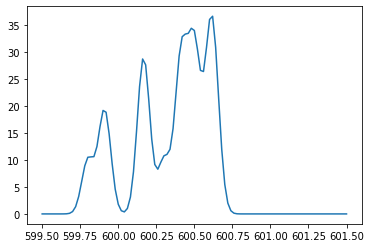

In [106]:
# instFRnow(self, fr, timePoint=0)
fr = vid_24116.instFR()
t = vid_24116.pos[0][:,0]
Fs, cnt = stats.mode(np.diff(t))
timePoint = 30025

# define range of points to pull from L/R sides of timePoint
plusMinus = int(1/Fs)

# index vectors, where len(frNow) = (plusMinus*2)+1
frNow = fr[timePoint-plusMinus:timePoint+plusMinus+1] 
timeNow = t[timePoint-plusMinus:timePoint+plusMinus+1]

# get sampling frequency
# t = self.pos[sessNum][:,0] # grab time vector
# Fs, cnt = stats.mode(np.diff(t)) # calc mode of sampling frequencies
# timePoint = 30025.0

plt.plot(timeNow, frNow)